In [88]:
import jax
	
import jax.numpy as jnp
import liesel.goose as gs
import plotnine as p9
import tensorflow_probability.substrates.jax.distributions as tfd
from jax import random
import pandas as pd
import matplotlib.pyplot as plt

import liesel.model as lsl
import numpy as np
import liesel_gam as gam
import liesel_ptm as ptm
from smoothcon import SmoothCon, SmoothFactory
from liesel.contrib.splines import equidistant_knots

import liesel_survival_ptm as surv

nobs = 500
key = jax.random.PRNGKey(0)  # generate PRNG keys
k1, k2, k3, k4 = jax.random.split(key=key, num=4)

log_eps = tfd.Normal(0.0, 1.0).sample(nobs, seed=k1)

x = tfd.Uniform(low=-2.0, high=2.0).sample(nobs, seed=k2)

intercept, beta = -2.0, 1.0
log_y = intercept + beta * x + log_eps

In [89]:
# Create a single indicator for censored data
censoring_indicator = tfd.Bernoulli(probs=0.20).sample(nobs, seed=k3)
u_lower = tfd.Uniform(low=log_y.min() - 1.0, high=log_y).sample(seed=k4)

lower_bound = jnp.full_like(log_y, jnp.nan)
upper_bound = jnp.full_like(log_y, jnp.nan)

lower_bound = jnp.where(censoring_indicator == 1, u_lower, lower_bound)
log_y_censored = jnp.where(censoring_indicator == 1, lower_bound, log_y)

log_y_obs = jnp.concatenate([log_y_censored[:, None], x[:, None], lower_bound[:, None], upper_bound[:, None], censoring_indicator[:, None]], axis=1)

In [90]:
log_y_obs_df = pd.DataFrame(log_y_obs, columns=["log_y", "x", "left_bound", "right_bound", "censoring_indicator"])
print(log_y_obs_df)

        log_y         x  left_bound  right_bound  censoring_indicator
0   -2.966810 -1.970825         NaN          NaN                  0.0
1   -4.822773 -1.916435         NaN          NaN                  0.0
2   -2.422466  0.325706         NaN          NaN                  0.0
3   -3.724015 -0.552648         NaN          NaN                  0.0
4   -3.979082 -1.107849         NaN          NaN                  0.0
..        ...       ...         ...          ...                  ...
495 -6.282077 -1.384963         NaN          NaN                  0.0
496 -1.561980  0.118146         NaN          NaN                  0.0
497 -7.184944  1.636643   -7.184944          NaN                  1.0
498 -4.512553 -1.432499   -4.512553          NaN                  1.0
499 -2.927264  0.204161         NaN          NaN                  0.0

[500 rows x 5 columns]


In [ ]:
jnp.exp(log_y).max()

Array(9.624074, dtype=float32)

In [92]:
jnp.exp(log_y).min()

Array(0.00186951, dtype=float32)

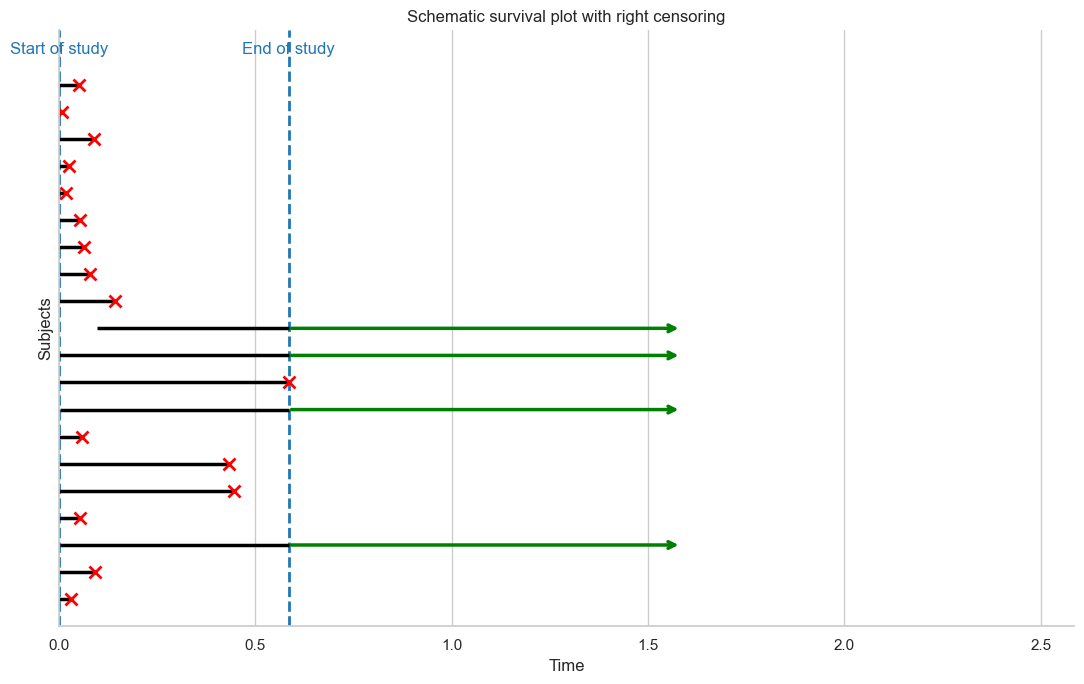

In [93]:
import numpy as np
import matplotlib.pyplot as plt

log_y_obs_df = pd.DataFrame(
    np.array(log_y_obs[:20]),
    columns=["log_y", "x", "left_bound", "right_bound", "censoring_indicator"],
)

is_obs = (log_y_obs_df["censoring_indicator"].astype(int) == 0)
is_rc  = (log_y_obs_df["censoring_indicator"].astype(int) == 1)

survival_time    = np.where(is_obs, np.exp(log_y_obs_df["log_y"]), np.nan)
lower_bound_time = np.where(is_rc,  np.exp(log_y_obs_df["left_bound"]), np.nan)

obs_max = np.nanmax(survival_time) if np.any(~np.isnan(survival_time)) else 1.0
lb_max  = np.nanmax(lower_bound_time) if np.any(~np.isnan(lower_bound_time)) else 1.0
study_start = 0.0
study_end   = obs_max
horizon     = max(obs_max, lb_max) + 1.0

df = pd.DataFrame({
    "survival_time": survival_time,
    "lower_bound_time": lower_bound_time,
    "is_obs": is_obs.values,
    "is_rc": is_rc.values,
})
df["row"] = np.arange(len(df), 0, -1)  # subject rows, top to bottom

fig, ax = plt.subplots(figsize=(11, 7))

ax.axvline(study_start, linestyle="--", color="tab:blue", linewidth=2)
ax.axvline(study_end,   linestyle="--", color="tab:blue", linewidth=2)
ax.text(study_start, df["row"].max()+1, "Start of study",
        color="tab:blue", ha="center", va="bottom")
ax.text(study_end,   df["row"].max()+1, "End of study",
        color="tab:blue", ha="center", va="bottom")

for _, r in df.iterrows():
    y = r["row"]
    if r["is_obs"]:
        ax.hlines(y, study_start, r["survival_time"], color="black", linewidth=2.5)
        ax.plot(r["survival_time"], y, marker="x", color="red",
                markersize=9, markeredgewidth=2)
    if r["is_rc"]:
        ax.hlines(y, r["lower_bound_time"], study_end, color="black", linewidth=2.5)
        ax.annotate("", xy=(horizon, y), xytext=(study_end, y),
                    arrowprops=dict(arrowstyle="->", linewidth=2.5, color="green"))

ax.set_ylim(0, df["row"].max() + 2)
ax.set_xlim(study_start, horizon + 1)
ax.set_xlabel("Time")
ax.set_ylabel("Subjects")
ax.set_title("Schematic survival plot with right censoring")
ax.set_yticks([])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.tight_layout()
plt.show()

In [94]:
class RightCensoredNormal(tfd.Distribution):
    """
    Minimal right-censored Normal in JAX/TFP with an indicator.

    Usage:
      dist = RightCensoredNormal(loc, scale, is_censored)
      logp = dist.log_prob(x)

    Semantics:
      - Uncensored (is_censored == 0):  log p(x) = Normal(loc, scale).log_prob(x)
      - Censored   (is_censored == 1):  log p(x) = log P(Y >= x)  (right-censoring at x)

    Shapes broadcast in the usual way. `is_censored` must be {0.0,1.0}.
    """

    def __init__(
        self,
        loc,
        scale,
        is_censored,
        validate_args=False,
        allow_nan_stats=True,
        name="RightCensoredNormal",
    ):
        parameters = dict(locals())
        self._loc = jnp.asarray(loc)
        self._scale = jnp.asarray(scale)
        self._is_censored = jnp.asarray(is_censored)
        self._normal = tfd.Normal(loc=self._loc, scale=self._scale)
        super().__init__(
            dtype=self._loc.dtype,
            reparameterization_type=tfd.NOT_REPARAMETERIZED,
            validate_args=validate_args,
            allow_nan_stats=allow_nan_stats,
            parameters=parameters,
            name=name,
        )

    def _log_prob(self, value):
        x = jnp.asarray(value)

        lp_unc = self._normal.log_prob(x) # Uncensored: density
        lp_cen = jnp.log(self._normal.survival_function(x)) # Censored: log survival

        return jnp.where(self._is_censored == 1.0, lp_cen, lp_unc)

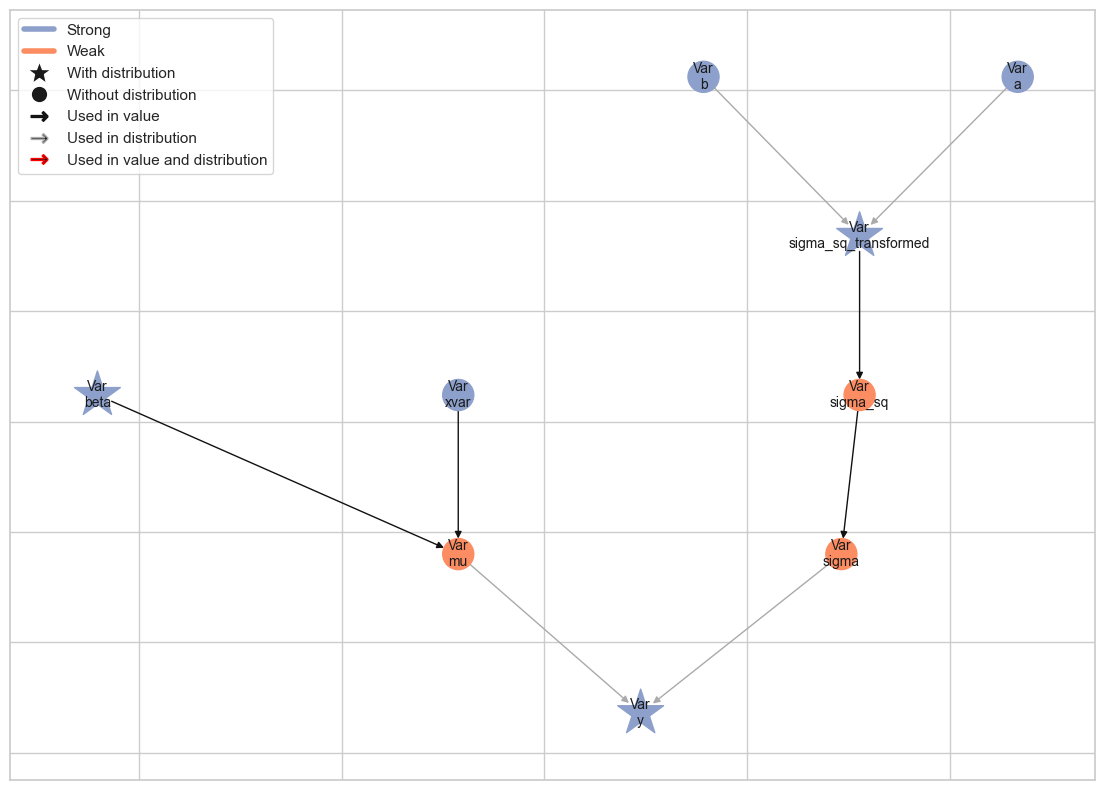

In [95]:
import liesel.model as lsl
import liesel.goose as gs
import tensorflow_probability.substrates.jax.bijectors as tfb

beta_prior = lsl.Dist(tfd.Normal, loc=0.0, scale=100.0)
beta = lsl.Var.new_param(
    value=jnp.array([0.0, 0.0]), 
    distribution=beta_prior, 
    name="beta",
    inference=gs.MCMCSpec(gs.NUTSKernel)
)

X_mat = np.column_stack([jnp.ones(nobs), x])
xvar = lsl.Var.new_obs(X_mat, name="xvar")
mu = lsl.Var.new_calc(jnp.dot, xvar, beta, name="mu")

a = lsl.Var.new_param(0.01, name="a")
b = lsl.Var.new_param(0.01, name="b")
sigma_sq_prior = lsl.Dist(tfd.InverseGamma, concentration=a, scale=b)
sigma_sq = lsl.Var.new_param(value=10.0, distribution=sigma_sq_prior, name="sigma_sq")
sigma_sq.transform(tfb.Exp(), inference=gs.MCMCSpec(gs.NUTSKernel))
sigma = lsl.Var.new_calc(jnp.sqrt, sigma_sq, name="sigma").update()

#loc = lsl.Var.new_param(mu, name="loc", inference=gs.MCMCSpec(gs.NUTSKernel))
dist = lsl.Dist(RightCensoredNormal, loc=mu, scale=sigma, is_censored=log_y_obs[:, 4])

#xvar = lsl.Var.new_obs(x, dist, name="x")

#y_dist = lsl.Dist(dist=dist, loc=mu, scale=1.0)
y = lsl.Var.new_obs(log_y_obs[:, 0], distribution=dist, name="y")

model = lsl.Model([y])
model.plot_vars()

In [96]:
eb = gs.LieselMCMC(model).get_engine_builder(seed=1, num_chains=4)
eb.set_duration(warmup_duration=300, posterior_duration=500)
engine = eb.build()
engine.sample_all_epochs()

result = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys 'sigma_sq_transformed', 'beta'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 75 transitions, 25 jitted together
100%|██████████████████████████████████████████| 3/3 [00:02<00:00,  1.07chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 2, 2, 2, 4 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_01: 2, 2, 3, 1 / 75 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|████████████████████████████████████████| 1/1 [00:00<00:00, 1574.44chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 1, 1, 1, 2 / 25 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_01: 1, 1, 1, 

In [97]:
gs.Summary(result)

Parameter summary:

                               kernel      mean        sd    q_0.05     q_0.5  \
parameter            index                                                      
beta                 (0,)   kernel_01 -1.969173  0.053905 -2.053872 -1.969350   
                     (1,)   kernel_01  1.038472  0.044150  0.965205  1.040091   
sigma_sq_transformed ()     kernel_00  0.069642  0.072707 -0.045245  0.067361   

                              q_0.95  sample_size     ess_bulk     ess_tail  \
parameter            index                                                    
beta                 (0,)  -1.878197         2000  1767.757379  1089.576504   
                     (1,)   1.109863         2000  1937.280993  1179.588494   
sigma_sq_transformed ()     0.191157         2000   672.722781   632.343667   

                                rhat  
parameter            index            
beta                 (0,)   1.001509  
                     (1,)   1.001594  
sigma_sq_transformed ()     1.003621  

Error summary:

                                                    count relative
kernel    error_code error_msg            phase                   
kernel_00 1          divergent transition warmup       33   0.0275
                                          posterior     0      0.0
kernel_01 1          divergent transition warmup       27   0.0225
                                          posterior     0      0.0

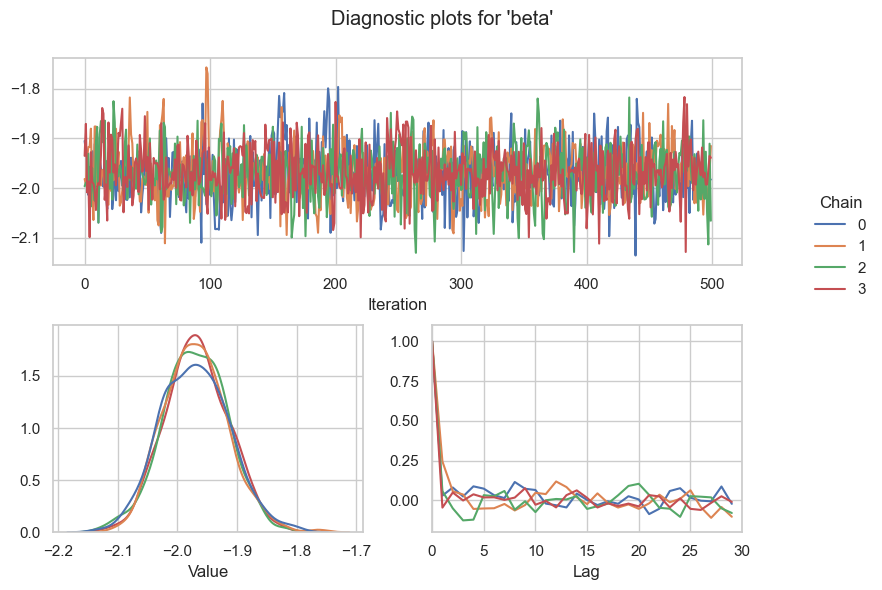

In [98]:
gs.plot_param(result, "beta",0)

### Gaussian model

liesel.model.model - INFO - Converted dtype of Value(name="xvar_value").value


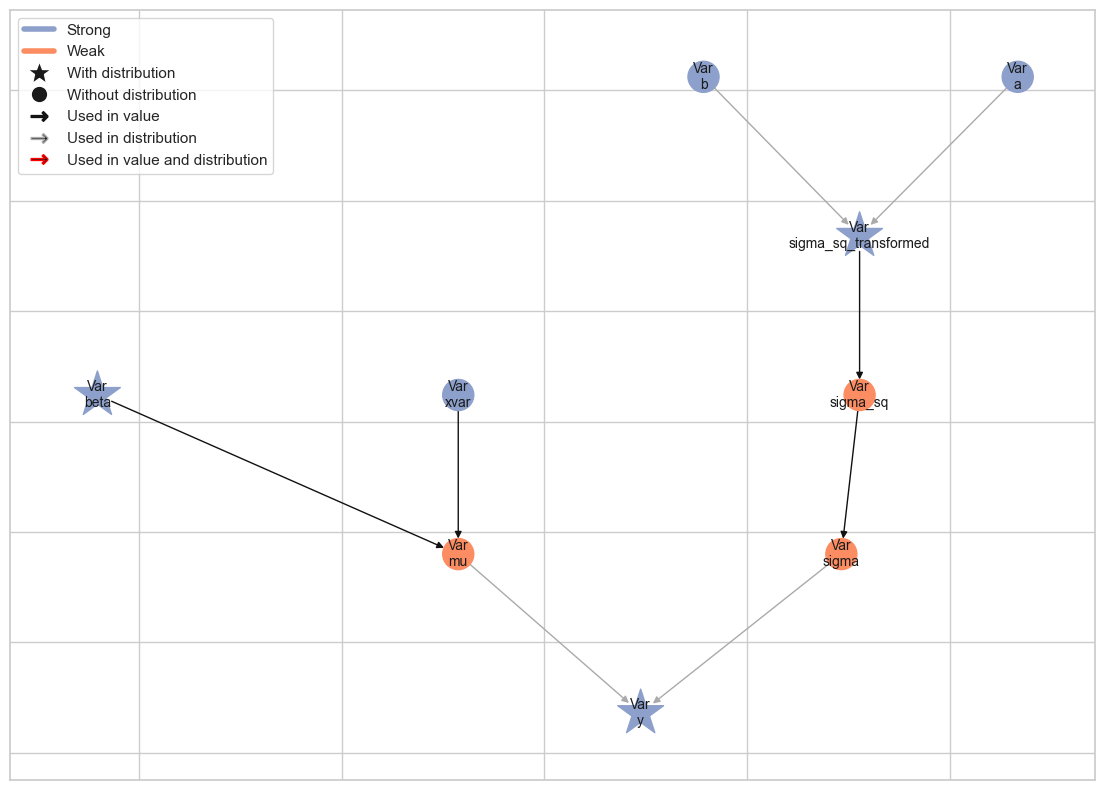

In [99]:
import liesel.model as lsl
import liesel.goose as gs

beta_prior = lsl.Dist(tfd.Normal, loc=0.0, scale=100.0)
beta = lsl.Var.new_param(value=jnp.array([0.0, 0.0]), distribution=beta_prior, name="beta", inference=gs.MCMCSpec(gs.NUTSKernel))

X_mat = np.column_stack([np.ones(nobs), x])
xvar = lsl.Var.new_obs(X_mat, name="xvar")
mu = lsl.Var.new_calc(jnp.dot, xvar, beta, name="mu")

a = lsl.Var.new_param(0.01, name="a")
b = lsl.Var.new_param(0.01, name="b")
sigma_sq_prior = lsl.Dist(tfd.InverseGamma, concentration=a, scale=b)
sigma_sq = lsl.Var.new_param(value=10.0, distribution=sigma_sq_prior, name="sigma_sq")
sigma_sq.transform(tfb.Exp(), inference=gs.MCMCSpec(gs.NUTSKernel))
sigma = lsl.Var.new_calc(jnp.sqrt, sigma_sq, name="sigma").update()

dist = lsl.Dist(tfd.Normal, loc = mu, scale = sigma)
y = lsl.Var.new_obs(log_y_obs[:, 0], distribution=dist, name="y")

model = lsl.Model([y])
model.plot_vars()

In [100]:
model.log_prob

Array(-1332.0942, dtype=float32)

In [101]:
eb = gs.LieselMCMC(model).get_engine_builder(seed=1, num_chains=4)
eb.set_duration(warmup_duration=300, posterior_duration=500)
engine = eb.build()
engine.sample_all_epochs()

result = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys 'sigma_sq_transformed', 'beta'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 75 transitions, 25 jitted together
100%|██████████████████████████████████████████| 3/3 [00:02<00:00,  1.31chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 2, 2, 2, 2 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_01: 1, 3, 1, 1 / 75 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 339.78chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 2, 1, 1, 2 / 25 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_01: 1, 1, 1, 

In [102]:
gs.Summary(result)

Parameter summary:

                               kernel      mean        sd    q_0.05     q_0.5  \
parameter            index                                                      
beta                 (0,)   kernel_01 -2.613816  0.075089 -2.737463 -2.614429   
                     (1,)   kernel_01  0.896986  0.065016  0.790093  0.896685   
sigma_sq_transformed ()     kernel_00  1.010592  0.065032  0.902926  1.012185   

                              q_0.95  sample_size     ess_bulk     ess_tail  \
parameter            index                                                    
beta                 (0,)  -2.488380         2000  1801.571272  1246.370325   
                     (1,)   0.999976         2000  1820.533436  1338.718149   
sigma_sq_transformed ()     1.113696         2000   656.262365   695.350978   

                                rhat  
parameter            index            
beta                 (0,)   1.002172  
                     (1,)   1.003706  
sigma_sq_transformed ()     1.002628  

Error summary:

                                                    count  relative
kernel    error_code error_msg            phase                    
kernel_00 1          divergent transition warmup       34  0.028333
                                          posterior     0       0.0
kernel_01 1          divergent transition warmup       23  0.019167
                                          posterior     0       0.0

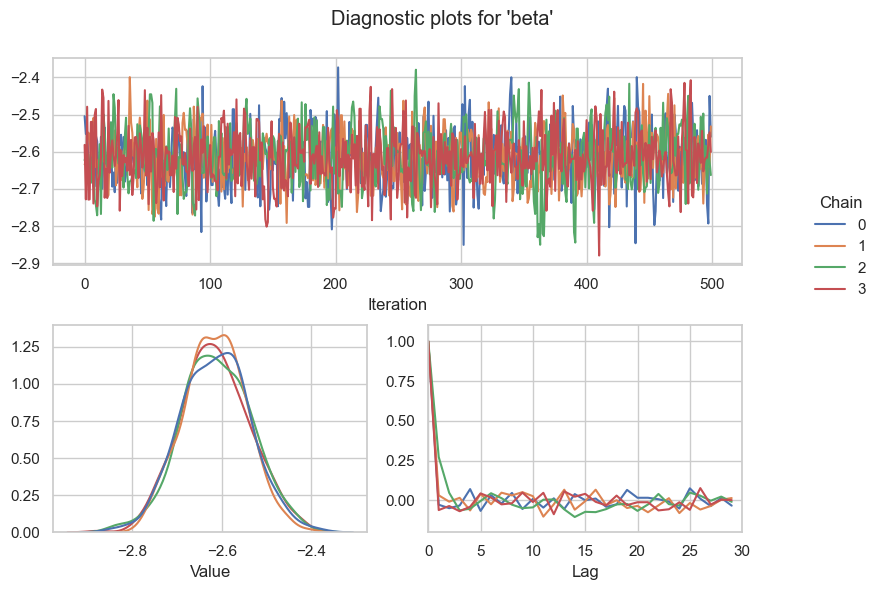

In [103]:
gs.plot_param(result, "beta", 0)